# Detection of ArUco Markers

## 1. Generating ArUco Markers

In [45]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from skimage import io
from PIL import Image
from scripts.cv2_imshow import cv2_imshow

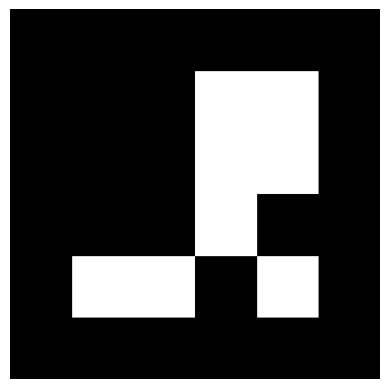

In [46]:
myDict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)

def generate_aruco(id, dictionary=cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50), size=500, filename='aruco.png'):
    # Generate the marker image
    img = cv2.aruco.generateImageMarker(dictionary, id, size)
    cv2.imwrite(f'img/{filename}', img)
    return img

# Generate ArUco tag with id 5
tag_1 = generate_aruco(2, dictionary=myDict, filename='aruco_2.png')

# Display the image
cv2_imshow(tag_1)

## Detecting Markers

Next step is to detect the tags on an input image

<img src="img/ArUco_test_1.png" width="500">

In [47]:
# load the image
test_1 = cv2.imread('img/ArUco_test_1.png')

markerIds = np.array([])

markerCorners = np.array([])
rejectedCandidates = np.array([])

detector_1 = cv2.aruco.ArucoDetector(myDict, detectorParams=cv2.aruco.DetectorParameters())
markerCorners, markerIds, rejectedCandidates = detector_1.detectMarkers(test_1, markerCorners, markerIds, rejectedCandidates)

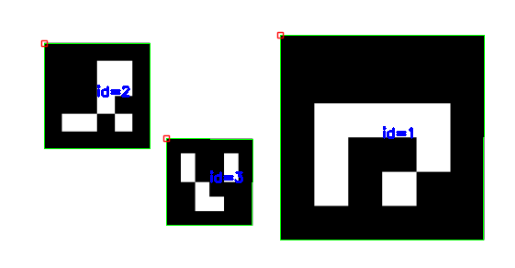

In [48]:
output_1 = test_1.copy()
output_1 = cv2.aruco.drawDetectedMarkers(output_1, markerCorners, markerIds, borderColor=(0, 255, 0))

cv2_imshow(output_1)

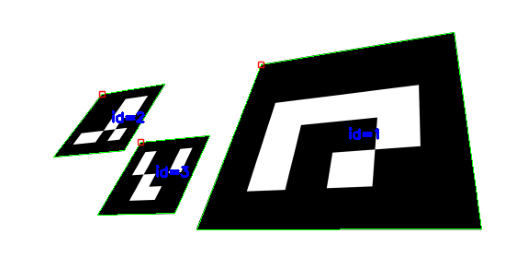

In [51]:
test_2 = cv2.imread('img/ArUco_test_2.png')
markerCorners, markerIds, rejectedCandidates = detector_1.detectMarkers(test_2, markerCorners, markerIds, rejectedCandidates)

output_2 = test_2.copy()
output_2 = cv2.aruco.drawDetectedMarkers(output_2, markerCorners, markerIds, borderColor=(0, 255, 0))

cv2_imshow(output_2)